<a href="https://colab.research.google.com/github/gowtham91m/Udacity_dog_breed_classification/blob/master/dog_app_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:

**Note: if you are using the Udacity workspace, you *DO NOT* need to re-download these - they can be found in the `/data` folder as noted in the cell below.**

* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dog_images`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [3]:
%%time
# https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
# https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip

import requests, zipfile, io, os, shutil
import numpy as np
from glob import glob

root = '/content'
dogimages_url = "https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip"
humanimages_url = "https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip"

data_path = os.path.join(root,'data')
dogimages_path = os.path.join(data_path,'dogImages')
humanimages_path = os.path.join(data_path,'lfw')
data_path = os.path.join(root,'data')
if not os.path.exists(data_path): os.mkdir(data_path)

# if os.path.exists(dogimages_path):shutil.rmtree(dogimages_path)
# if os.path.exists(humanimages_path):shutil.rmtree(humanimages_path)

if not os.path.exists(dogimages_path):
  print("downloading dog images")
  r = requests.get(dogimages_url) 
  z = zipfile.ZipFile(io.BytesIO(r.content)) 
  z.extractall(data_path)

if not os.path.exists(humanimages_path):
  print("downloading human images")
  r = requests.get(humanimages_url) 
  z = zipfile.ZipFile(io.BytesIO(r.content)) 
  z.extractall(data_path)

# load filenames for human and dog images
human_files = np.array(glob("/content/data/lfw/*/*"))
dog_files = np.array(glob("/content/data/dogImages/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

downloading dog images
downloading human images
There are 13233 total human images.
There are 8351 total dog images.
CPU times: user 13 s, sys: 5.65 s, total: 18.7 s
Wall time: 34.3 s


In [0]:
# !ls /content/data/dogImages/train/ | wc -l
# import os
# os.chdir('/content/data/dogImages/train')
# !find -maxdepth 1 -type d | sort | while read -r dir; do n=$(find "$dir" -type f | wc -l); printf "%4d : %s\n" $n "$dir"; done

In [5]:
if not os.path.exists('/content/haarcascades'): os.mkdir('/content/haarcascades')
haarcascades_url = 'https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_alt.xml'
!wget -O /content/haarcascades/haarcascade_frontalface_alt.xml {haarcascades_url}

--2019-12-30 01:53:48--  https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_alt.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 676709 (661K) [text/plain]
Saving to: ‘/content/haarcascades/haarcascade_frontalface_alt.xml’

/content/haarcascad 100%[===================>] 660.85K  --.-KB/s    in 0.05s   

2019-12-30 01:53:48 (12.6 MB/s) - ‘/content/haarcascades/haarcascade_frontalface_alt.xml’ saved [676709/676709]



<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


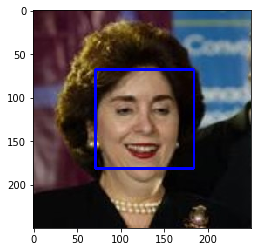

In [6]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('/content/haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[1])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [0]:
# returns "True" if face is detected in image stored at img_path
def haar_face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

98% of images are detected as human face from human_files_short

6% of images are detected as human face from dog_files_short 

In [8]:
%%time
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]
#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

human_files_count=0
dog_files_count=0
for i in range(len(human_files_short)):
    if haar_face_detector(human_files_short[i]):
        human_files_count+=1
    if haar_face_detector(dog_files_short[i]):
        dog_files_count+=1
print("number of human faces detected in human_fiiles_hort {0}".format(human_files_count))
print("number of human faces detected in dog_files_short {0}".format(dog_files_count))

number of human faces detected in human_fiiles_hort 98
number of human faces detected in dog_files_short 6
CPU times: user 1min 1s, sys: 96.9 ms, total: 1min 1s
Wall time: 32.3 s


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [0]:
### (Optional) 
### TODO: Test performance of anotherface detection algorithm.
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [10]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:33<00:00, 16.7MB/s]


Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [11]:
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets
import os

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    
    # data transformation
    batch_size = 64
    img = Image.open(img_path).convert('RGB')
    image_transforms = transforms.Compose([
                            transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
                            transforms.RandomRotation(degrees=15),
                            transforms.ColorJitter(),
                            transforms.RandomHorizontalFlip(),
                            transforms.CenterCrop(size=224),  # Image net standards
                            transforms.ToTensor(),
                            transforms.Normalize([0.485, 0.456, 0.406],
                                                 [0.229, 0.224, 0.225])  # Imagenet standards
                        ])
    
    image = image_transforms(img)[:3,:,:].unsqueeze(0)
#     image = image_transforms(img)
#     print(image_transformation)
    
    if use_cuda:
        image = image.cuda()
    output = VGG16(image)

    _,pred = torch.max(output, dim=1)
    pred=pred.cpu()
    pred = pred.data.numpy()[0]
        
    return pred # predicted class index

VGG16_predict(dog_files[0])

180

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [12]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
#     in VGG16 index 151 to 268 are dog classifications
    
    return VGG16_predict(img_path)>= 151 and VGG16_predict(img_path)<=268 # true/false
print(dog_detector(human_files[3]))
print(dog_detector(dog_files[7]))

False
True


### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

4% of images in human_files_short are detected as dog images

100% of images in dog files are detected as dog images


In [13]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

human_files_count=0
dog_files_count=0
for i in range(len(human_files_short)):
    if dog_detector(human_files_short[i]):
        human_files_count+=1
    if dog_detector(dog_files_short[i]):
        dog_files_count+=1
print("number of dog faces detected in human_fiiles_short {0}".format(human_files_count))
print("number of dog faces detected in dog_files_short {0}".format(dog_files_count))


number of dog faces detected in human_fiiles_short 6
number of dog faces detected in dog_files_short 99


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [0]:
### (Optional) 
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dog_images/train`, `dog_images/valid`, and `dog_images/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [0]:
## TODO: Specify data loaders
import os
import torch
import torchvision
from torchvision import datasets
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
image_datasets = {x: datasets.ImageFolder(os.path.join(dogimages_path,x),data_transforms[x])
                    for x in ['train','valid','test']}
dataloaders ={x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
                    for x in ['train','valid','test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train','valid','test']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?

several processing steps are performed.

1. resize - since single digit is given, small edge of the image will be matched with this number and the larger edge of the image will be scaled accordingly.

  for example if the image size is (h,w) (300,400) 

  it will be resized to (256, 256*(400/300))

2. image center crop will do the similar transformation as the resize except that it will crop the image and take the center part of the image ignoring the edges. 

3. to tensor - image is converted from numpy array to tensor

- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

1. random horizontal flip is performed to only train data to generalize the model. model should be able to predict the dog even if the image is fliped horizontally.


**Answer**:

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [0]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 3)
        self.conv2 = nn.Conv2d(64, 64, 3)
        self.conv3 = nn.Conv2d(64, 64, 3)
        # self.conv4 = nn.Conv2d(in_channels = 128, out_channels =  128, kernel_size = 3,padding=1)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        
        self.fc1 = nn.Linear(64 * 26 * 26, 256)
        self.fc2 = nn.Linear(256, 133)
        # self.softmax = nn.Softmax(dim=1)
        self.batch_norm = nn.BatchNorm1d(num_features=500)
    
    def forward(self, x):
        ## Define forward behavior
        x = self.pool(F.relu(self.conv1(x)))
        # x = self.dropout(x)
        x = self.pool(F.relu(self.conv2(x)))
        # x = self.dropout(x)
        x = self.pool(F.relu(self.conv3(x)))
        # x = self.dropout(x)
        
        # print(x.size())
        
        # x = x.view(-1, 64 * 4 * 4)
        x = x.view(x.size(0), -1)
        # x = F.relu(self.batch_norm(self.fc1(x)))
        # print(x.size())
        x = F.relu(self.fc1(x))
        # print(x.size())
        # x = self.dropout(x)
        x = self.fc2(x)
        return x

#-#-# You so NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
# use_cuda = False
if use_cuda:
    model_scratch.cuda()

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 

I have choosen to build a basic CNN artecheture with 3 CNN layers with 64 nodes and one fully connected layer with 256 nodes.

relu activation function for each layer. max pool is applyed to each of cnn layer.

final fully connected node does not have any activation like softmax because i am not interested in prediction probobilities here. i only need to get one prediction out of 133 classes. cross entropy loss will handle this situation. 

didn't do much fine tuning in this model artecheture sine i will be working on transfer leanring in the next step that should ideally give better performance instead of training the whole network with limitted amount of images.


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [0]:
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn as nn

### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_scratch, step_size=7, gamma=0.1)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [18]:
# train the model
import time
import copy
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def model_transfer(model, criterion, optimizer, scheduler, num_epochs,dataloaders):
  since = time.time()
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc=0.0
  
  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs -1))
    print('-'*10)

    # Each epoch has a training and validation phase
    for phase in ['train','valid']:
      if phase == 'train':
        model.train()
      else:
        model.eval()
      
      running_loss = 0.0
      running_corrects = 0

      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        with torch.set_grad_enabled(phase=='train'):
          outputs = model(inputs)
          _, preds = torch.max(outputs,1)
          loss = criterion(outputs,labels)

          if phase =='train':
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
      if phase =='train':
        scheduler.step()
      
      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double() / dataset_sizes[phase]

      print('{} Loss: {: 4f} Acc: {:.4f}'.format(
          phase, epoch_loss, epoch_acc))
      
      if phase=='valid' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
    print()
  time_elapsed = time.time() - since
  print('training complete in {:.0f}m {:.0f}s'.format(
      time_elapsed //60, time_elapsed % 60))
  model.load_state_dict(best_model_wts)
  return model

# model_transfer = # train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')
model = model_transfer(model_scratch, criterion_scratch, optimizer_scratch, exp_lr_scheduler,num_epochs=8,dataloaders=dataloaders)

# model_scratch = train(4, loaders_scratch, model_scratch, optimizer_scratch, 
#                       criterion_scratch, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy (uncomment the line below)
#model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch 0/7
----------
train Loss:  4.742957 Acc: 0.0205
valid Loss:  4.516610 Acc: 0.0419

Epoch 1/7
----------
train Loss:  4.390155 Acc: 0.0470
valid Loss:  4.406501 Acc: 0.0467

Epoch 2/7
----------
train Loss:  4.190549 Acc: 0.0675
valid Loss:  4.233041 Acc: 0.0575

Epoch 3/7
----------
train Loss:  3.958884 Acc: 0.0979
valid Loss:  4.148956 Acc: 0.0707

Epoch 4/7
----------
train Loss:  3.695363 Acc: 0.1443
valid Loss:  4.156148 Acc: 0.0910

Epoch 5/7
----------
train Loss:  3.354215 Acc: 0.2067
valid Loss:  4.065562 Acc: 0.1066

Epoch 6/7
----------
train Loss:  2.887705 Acc: 0.2979
valid Loss:  4.144174 Acc: 0.1042

Epoch 7/7
----------
train Loss:  1.668104 Acc: 0.5951
valid Loss:  4.606009 Acc: 0.1078

training complete in 10m 8s


### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [0]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    


In [20]:
test(dataloaders, model_scratch, criterion_scratch, use_cuda)

Test Loss: 4.617095


Test Accuracy: 12% (104/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [0]:
## TODO: Specify data loaders
import os
import torch
import torchvision
from torchvision import datasets
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
image_datasets = {x: datasets.ImageFolder(os.path.join(dogimages_path,x),data_transforms[x])
                    for x in ['train','valid','test']}
dataloaders ={x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
                    for x in ['train','valid','test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train','valid','test']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

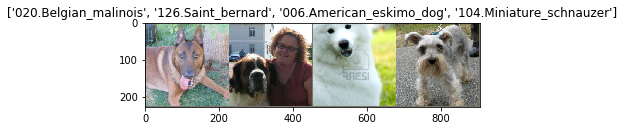

In [22]:
def imshow(inp, title=None):
  """Imshow for Tensor."""
  # print(type(inp.numpy()))
  # print(inp.numpy().shape)
  # print(inp.numpy().transpose(1,2,0).shape)
  inp = inp.numpy().transpose((1,2,0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
        plt.title(title)
  plt.pause(0.001)  # pause a bit so that plots are updated

inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [23]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

## TODO: Specify model architecture 

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 133)
model_ft =model_ft.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 25.3MB/s]


__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 

Here i am using resnet18 pretrained network. I have choosen to finetune the network with dog breed dataset.

added a fully connected layer at the end with 133 nodes.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [25]:
# train the model
import time
import copy
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def model_transfer(model, criterion, optimizer, scheduler, num_epochs=8):
  since = time.time()
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc=0.0
  
  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs -1))
    print('-'*10)

    # Each epoch has a training and validation phase
    for phase in ['train','valid']:
      if phase == 'train':
        model.train()
      else:
        model.eval()
      
      running_loss = 0.0
      running_corrects = 0

      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        with torch.set_grad_enabled(phase=='train'):
          outputs = model(inputs)
          _, preds = torch.max(outputs,1)
          loss = criterion(outputs,labels)

          if phase =='train':
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
      if phase =='train':
        scheduler.step()
      
      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double() / dataset_sizes[phase]

      print('{} Loss: {: 4f} Acc: {:.4f}'.format(
          phase, epoch_loss, epoch_acc))
      
      if phase=='valid' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
    print()
  time_elapsed = time.time() - since
  print('training complete in {:.0f}m {:.0f}s'.format(
      time_elapsed //60, time_elapsed % 60))
  model.load_state_dict(best_model_wts)
  return model

# model_transfer = # train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')
model = model_transfer(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=8)

# load the model that got the best validation accuracy (uncomment the line below)
#model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch 0/7
----------
train Loss:  2.796270 Acc: 0.3365
valid Loss:  1.045270 Acc: 0.6766

Epoch 1/7
----------
train Loss:  1.437730 Acc: 0.5930
valid Loss:  0.870760 Acc: 0.7222

Epoch 2/7
----------
train Loss:  1.046601 Acc: 0.7043
valid Loss:  0.812029 Acc: 0.7677

Epoch 3/7
----------
train Loss:  0.827071 Acc: 0.7620
valid Loss:  0.667705 Acc: 0.7976

Epoch 4/7
----------
train Loss:  0.614387 Acc: 0.8305
valid Loss:  0.688050 Acc: 0.7868

Epoch 5/7
----------
train Loss:  0.503528 Acc: 0.8581
valid Loss:  0.635115 Acc: 0.8048

Epoch 6/7
----------
train Loss:  0.388758 Acc: 0.8972
valid Loss:  0.642394 Acc: 0.8036

Epoch 7/7
----------
train Loss:  0.226449 Acc: 0.9469
valid Loss:  0.447534 Acc: 0.8419

training complete in 10m 52s


### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [26]:
test(dataloaders, model_ft, criterion, use_cuda=True)

Test Loss: 0.508594


Test Accuracy: 84% (705/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [0]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
# class_names = [item[4:].replace("_", " ") for item in data_transfer['train'].classes]
from PIL import Image
import numpy as np
from skimage import transform

def load(filename):
   np_image = Image.open(filename)
   np_image = np.array(np_image).astype('float32')/255
   np_image = transform.resize(np_image, (3,150, 150))
   np_image = np.expand_dims(np_image, axis=0)
   image = torch.from_numpy(np_image)
   return image

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
  image = load(img_path)
  # y_prob = model.predict(image)
  image = image.to(device)
  y_prob = model(image)
  y_class = y_prob.argmax(axis=-1)
  # print(y_classes)
  # labels = (train_generator.class_indices)
  labels = image_datasets['train'].classes
  # labels = dict((v,k) for k,v in labels.items())
  prediction = [labels[k] for k in y_class]
  return prediction    

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [0]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    if haar_face_detector(img_path):
      print('hello human')
      prediction = predict_breed_transfer(img_path)
      print(prediction)
    elif dog_detector(img_path):
      print('hello dog')
      prediction = predict_breed_transfer(img_path)
      print(prediction)
    else:
      print("couldn't detect dog or human image")



---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)

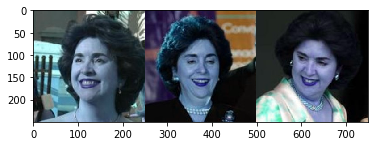

In [29]:
human_image_1=cv2.imread(human_files[0])
human_image_2=cv2.imread(human_files[1])
human_image_3=cv2.imread(human_files[2])
human_images = np.hstack((human_image_1,human_image_2,human_image_3))
plt.imshow(human_images)
plt.show()

Dalmatian-Temperament


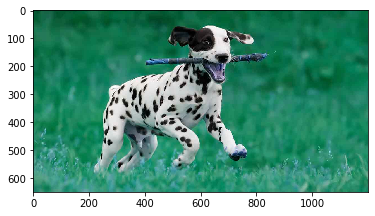

american-foxhound


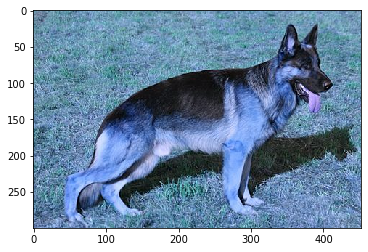

german-shepherd


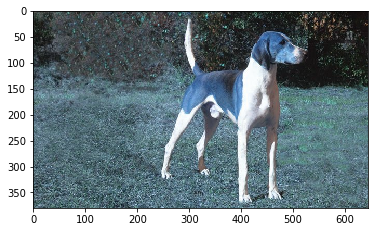

In [79]:
import cv2
dalmation_url = "https://thehappypuppysite.com/wp-content/uploads/2019/01/Dalmatian-Temperament-long.jpg"
foxhound_url = "https://vetstreet.brightspotcdn.com/dims4/default/ee10448/2147483647/crop/0x0%2B0%2B0/resize/645x380/quality/90/?url=https%3A%2F%2Fvetstreet-brightspot.s3.amazonaws.com%2Fe9%2F579150a41a11e087a80050568d634f%2Ffile%2FAmerican-Foxhound-1-645mk062311.jpg"
german_shepherd_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/8/88/Deutscher_Schaeferhund_Presley_von_Beluga.jpg/452px-Deutscher_Schaeferhund_Presley_von_Beluga.jpg"
!wget -nc {dalmation_url} >/dev/null 2>&1
!wget -nc {foxhound_url} >/dev/null 2>&1
!wget -nc {german_shepherd_url} >/dev/null 2>&1

dalmation_path ="/content/Dalmatian-Temperament-long.jpg"
foxhound_path ="/content/452px-Deutscher_Schaeferhund_Presley_von_Beluga.jpg"
german_shepherd_path="/content/index.html?url=https:%2F%2Fvetstreet-brightspot.s3.amazonaws.com%2Fe9%2F579150a41a11e087a80050568d634f%2Ffile%2FAmerican-Foxhound-1-645mk062311.jpg"

def np_imshow(img_path,label=None):
  img = cv2.imread(img_path)
  print(label)
  plt.imshow(img)
  plt.show()
np_imshow(dalmation_path,"Dalmatian-Temperament")
np_imshow(foxhound_path,"american-foxhound")
np_imshow(german_shepherd_path,"german-shepherd")

In [78]:
run_app(dalmation_path)
print()
run_app(foxhound_path)
print()
run_app(german_shepherd_path)

hello dog
['124.Poodle']

hello dog
['124.Poodle']

hello dog
['124.Poodle']


None


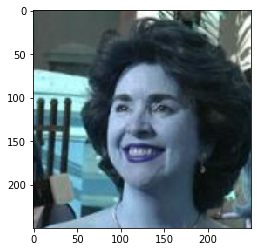

hello human
['123.Pomeranian']
None


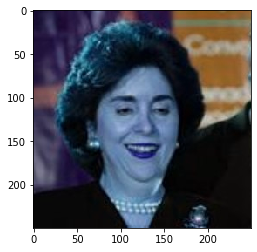

hello human
['124.Poodle']
None


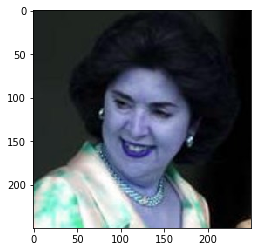

hello human
['124.Poodle']
None


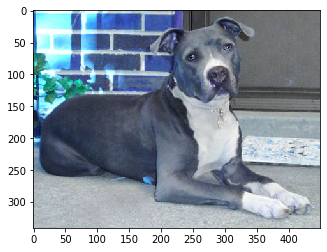

hello dog
['124.Poodle']
None


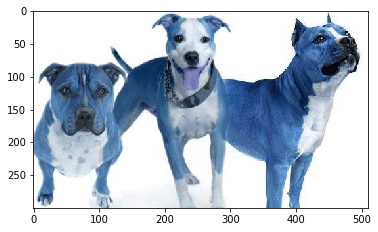

hello human
['124.Poodle']
None


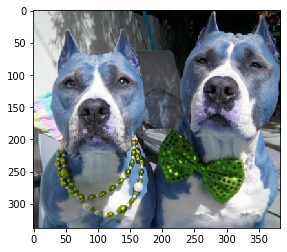

hello dog
['124.Poodle']


In [81]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

## suggested code, below
for file in np.hstack((human_files[:3], dog_files[:3])):
  np_imshow(file)
  run_app(file)

Reference https://towardsdatascience.com/transfer-learning-with-convolutional-neural-networks-in-pytorch-dd09190245ce